In [1]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn import preprocessing
import matplotlib.pyplot as plt
min_max_scaler=preprocessing.MinMaxScaler()
import warnings
warnings.filterwarnings('ignore')
import glob
from sklearn.decomposition import FactorAnalysis
import os.path
from sets import Set
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import random
from sklearn.utils import shuffle
from sklearn.feature_extraction import DictVectorizer
import pandas as pd



In [2]:
maxNoOfCircle = 30

In [3]:
L_n=5
maxNoOfIterations = 10000
min_del_e=0.0001
trainCircles = '../data/circles/train/*.circles'
testCircles = '../data/circles/test/*.circles'
featureFile ='../data/features/features_massaged.txt'
trainEgoNetFiles ='../data/egonets/train/*.egonet'
featureSet=["birthday","education;classes;description","education;classes;from;id","education;classes;from;name","education;classes;id","education;classes;name","education;classes;with;id","education;classes;with;name","education;concentration;id","education;concentration;name","education;degree;id","education;degree;name","education;school;id","education;school;name","education;type","education;with;id","education;with;name","education;year;id","education;year;name","first_name","gender","hometown;id","hometown;name","id","languages;id","languages;name","last_name","locale","location","location;id","location;name","middle_name","name","political","religion","work;description","work;employer;id","work;employer;name","work;end_date","work;from;id","work;from;name","work;location;id","work;location;name","work;position;id","work;position;name","work;projects;description","work;projects;end_date","work;projects;from;id","work;projects;from;name","work;projects;id","work;projects;name","work;projects;start_date","work;projects;with;id","work;projects;with;name","work;start_date","work;with;id","work;with;name"]

In [4]:
def loadFeatures(featureFile):
    nodesFeatures = open(featureFile, 'r')
    U=[]
    F_u=[]
    F_u_dict={}
    for nodeFeaturesText in nodesFeatures:
        nodeFeatures = nodeFeaturesText.split(' ')
        node = nodeFeatures[0]
        U.append(node)
        featureValue={}
        for featureValueText in nodeFeatures[1:]:
            featureValuePair=featureValueText.split(':')
            featureValue[featureValuePair[0]]=featureValuePair[1]
        f_u=[]
        for idx in range(len(featureSet)):
            f_u_i='-1'
            if(featureSet[idx] in featureValue):
                f_u_i = featureValue[featureSet[idx]].strip()
            f_u.append(f_u_i)
        F_u.append(f_u)
        F_u_dict[node]=f_u
    df=pd.DataFrame(F_u,  columns=featureSet)
    #print df
    vec = DictVectorizer()
    vec.fit(df.apply(lambda x: x.to_dict(), axis=1).tolist())
    Fd=vec.transform(df.apply(lambda x: x.to_dict(), axis=1).tolist()).shape[1]
    for u in F_u_dict:
        F_u_dict[u]
    return U,F_u_dict,vec,Fd
            
        

In [5]:
#loadFeatures(featureFile)

In [6]:
def loadGraph(egoNetFile):
    egoNet = open(egoNetFile, 'r')
    alter = os.path.basename(egoNetFile).split('.')[0]
    uv={}
    U=Set()
    nodeLookUp=initNodeLookup()
    for uvs in egoNet:
        u=uvs.split(':')[0].strip()
        U.add(u)
        vs=uvs.split(':')[1].split(' ')
        for v in vs:
            v=v.strip()
            if(len(v)!=0):
                int(u)
                int(v)
                uv[(u,v)]=1
                U.add(v)
    edgeUtilMat = np.zeros((len(U),len(U)))
    U=list(U)
    for u in U:
        for v in U:
            edge=0
            if((u,v) in uv):
                edge=uv[(u,v)]
            if(u==v):
                edge=1
            edgeUtilMat[getNodeId(u,nodeLookUp),getNodeId(v,nodeLookUp)] = edge 
    return alter,uv,U,edgeUtilMat,nodeLookUp
    

In [7]:
def loadGraphs(egoNetFile):
    uv_c={}
    for egoNetFile in glob.glob(egoNetFile):
        alter,uv=loadGraph(egoNetFile)
        uv_c[alter]=uv
    return uv_c


In [8]:
noOfNodes=100
noOfTestSamples=int(0.2*noOfNodes)
testSetExpected=np.zeros((noOfNodes,noOfNodes))
testSetIdxs=np.random.randint(0,noOfNodes-1,noOfTestSamples)

def initNodeLookup():
    nodeLookUp={}
    nodeLookUp['max']=-1
    return nodeLookUp
    

In [9]:
def getNodeId(rawId,nodeLookUp):
    rawId = rawId.strip()
    if rawId in nodeLookUp:
        nodeId = nodeLookUp[rawId]
    else:
        nodeIdx=nodeLookUp['max']
        nodeIdx=1+nodeIdx
        nodeLookUp['max']=nodeIdx
        nodeId = nodeIdx
        nodeLookUp[rawId] = nodeId
    return nodeId

In [10]:
def loadCircle(circleFile,nodeLookUp):
    alter = os.path.basename(circleFile).split('.')[0]
    circles = open(circleFile, 'r')
    nodesInCircle=Set()
    for circle in circles:
        nodesInCircle |= Set(circle.split(' ')[1:])
    N=len(nodeLookUp)-1
    utilMat = np.zeros((N,N))
    circles = open(circleFile, 'r')
    for circle in circles:
        nodesInCircle = circle.split()[1:]
        for u in nodesInCircle:
            for v in nodesInCircle:
                #print 'u',u,getNodeId(u,nodeLookUp)
                #print 'v',v,getNodeId(v,nodeLookUp)
                u_idx=getNodeId(u,nodeLookUp)
                v_idx=getNodeId(v,nodeLookUp)
                utilMat[u_idx,v_idx]=utilMat[u_idx,v_idx]+1
    return utilMat

#print loadCircle(trainCircles)

In [11]:
def getFeaturesOfM(F_U,nodeLookUp):
    Fm={}
    for u in nodeLookUp:
        if u!='max':
            Fm[nodeLookUp[u]]=F_U[u]
    return Fm

In [12]:
def loadTrainData(featureFile,trainEgoNetFiles,trainCircles):
    U,F_u_dict,vec,Fd=loadFeatures(featureFile)
    E_uv={}
    C={}
    F_U={}
    for egoNetFile in glob.glob(trainEgoNetFiles):
        alter,uv_m,U,E_uv_m,nodeLookUp=loadGraph(egoNetFile)
        C_m=loadCircle(trainCircles.replace('*',alter),nodeLookUp)
        #print 'alter:',alter
        F_U_m=[]
        for u in U:
            F_U_m.append(F_u_dict[u]) 
        E_uv[alter]=E_uv_m
        C[alter]=C_m
        F_U[alter]=F_U_m
    return F_U,vec,Fd,E_uv,C


In [13]:
F_U,vec,Fd,E_UV,C=loadTrainData(featureFile,trainEgoNetFiles,trainCircles)
print 'F_U,E_UV,C',len(F_U),',',len(E_UV),',',len(C)



F_U,E_UV,C 40 , 40 , 40


In [24]:
def train(F_U,vec,Fd,E_UV,C,alpha,lambda_,maxItr):
    print Fd
    Wa=np.random.rand(Fd,10)/10000
    We=np.random.rand(1,1)
    J=[]
    for itr in range(maxItr):
        print 'itr',itr
        for alter in E_UV:
            Fm=F_U[alter]
            Em=E_UV[alter]
            Cm=C[alter]
            N = Em.shape[0]
            print 'alter,N',alter,N
            F_vec={}
            for u in range(N-1):
                J_W=0
                Fu=vec.transform(pd.DataFrame(np.asarray(Fm[u]).reshape(1,57),  columns=featureSet).apply(lambda x: x.to_dict(), axis=1).tolist())
                for v in  range(u+1,N):
                    Fv=vec.transform(pd.DataFrame(np.asarray(Fm[v]).reshape(1,57),  columns=featureSet).apply(lambda x: x.to_dict(), axis=1).tolist())
                    FuWa=Fu*Wa
                    FvWaT=np.transpose(Fv*Wa)
                    intermediate = (Cm[u,v]-np.asscalar(np.dot(FuWa,FvWaT)) - np.asscalar(Em[u,v]*We))
                    Wa=Wa-alpha*(-2*intermediate*(np.transpose(Fv)*Fu + np.transpose(Fu)*Fv)*Wa)
                    We=We-alpha*(-2*intermediate*np.transpose(Em[u,v]) )
                    J_W+=np.square(intermediate) 
                J_W=(J_W/(N-u))
                circleError=J_W
                J_W = J_W +lambda_*(np.sum(np.square(Wa))+np.sum(np.square(We)))
                print u,circleError,J_W,We,np.sum(np.square(Wa))
                J.append(J_W)
            print '==============================='
    return J
        

In [ ]:
J=train(F_U,vec,Fd,E_UV,C,0.001,0,10)

183305
itr 0
alter,N 16642 227
0 0.0464163945691 0.0464163945691 [[ 0.17675402]] 0.00615914042525
1 0.0397441621027 0.0397441621027 [[ 0.18578898]] 0.00658998754317
2 1.05146702834 1.05146702834 [[ 0.30048855]] 0.0274709255767
3 0.0557329207322 0.0557329207322 [[ 0.29401733]] 0.0184614242106
4 0.980499418525 0.980499418525 [[ 0.33129589]] 0.0301560385899
5 0.34183388073 0.34183388073 [[ 0.34847773]] 0.0436684982332
6 0.823675063508 0.823675063508 [[ 0.38980925]] 0.0895678220161
7 0.0423726926312 0.0423726926312 [[ 0.39001173]] 0.0842973448018
8 1.17566104993 1.17566104993 [[ 0.39001173]] 0.103406974057
9 0.508534789568 0.508534789568 [[ 0.46541288]] 0.09105574318
10 0.933049340177 0.933049340177 [[ 0.53245842]] 0.103418266664
11 0.75471609429 0.75471609429 [[ 0.5607588]] 0.138431567876
12 0.0470830850499 0.0470830850499 [[ 0.5607588]] 0.135148024381
13 0.605228514991 0.605228514991 [[ 0.56274946]] 0.19888996952
14 0.0083620615768 0.0083620615768 [[ 0.5570528]] 0.197437789852
15 0.46386

In [ ]:
import matplotlib.pyplot as plt
plt.plot(J)
plt.ylabel('loss function')
plt.show()

In [10]:
def generateFeatures(F_u,uv,u,v):
    e_uv=0
    if (u==v) or ((u,v) in uv):
        e_uv=1
    f_u=np.array(F_u[int(u)])
    f_v=np.array(F_u[int(v)])
    X_uv=((f_u == f_v) == (f_u>-1)).astype(int)
    X_uv = np.append(X_uv,e_uv)
    return X_uv

In [11]:
def trainNodeEmbedding(k,circleFiles,egoNetFile,featureFile):
    F_uv=[]
    N_uv=[]
    uv_c=loadGraphs(egoNetFile)
    F_u=loadFeatures(featureFile)
    circleInfo = loadCircle(circleFiles)
    for alter in circleInfo:
        uv=uv_c[alter]
        nodeInvIdx=circleInfo[alter]['invIdx']
        for i in range(len(nodeInvIdx)):
            for j in range(i,len(nodeInvIdx)):
                u=nodeInvIdx[i]
                v=nodeInvIdx[j]
                F_uv.append(generateFeatures(F_u,uv,u,v))
                N_uv.append(circleInfo[alter]['uv'][(i,j)])
    
    trainWs(C,F_uv,Em,10,1)
    print 'F_uv,N_uv:',len(F_uv),len(N_uv)
    fa.fit_transform(F_uv,N_uv) # as per documentation only fit_transform uses y
    return fa


In [12]:
def trainCommunityMembership(utilMat,noOfCircle):
    circleModel = NMF(n_components=noOfCircle,solver='cd',l1_ratio=0,alpha=1,tol=0.000001,init='nndsvd',nls_max_iter=10000,max_iter=10000)
    circleModel.fit(utilMat)
    return circleModel
            

In [13]:
def predictANodeCommunityMembership(utilMat,circleModel):
    return circleModel.transform(utilMat)

In [14]:
def fitForCommunintyMembership(utilMat,noOfCircle):
    circleModel = trainCommunityMembership(utilMat,noOfCircle)
    F_u_c = predictANodeCommunityMembership(utilMat,circleModel)
    return F_u_c

In [15]:
def buildUtilMatFromCircleMembership(F_u_c):
    return np.dot(F_u_c,np.transpose(F_u_c))

In [16]:
def computeFittingError(F_uv_l,F_uv_c):
    return np.sum((F_uv_l-F_uv_c)**2)
    

In [17]:
def initUtilMatrix(N,k):
    mat = np.ones((N,N))
    for i in range(N):
        for j in range(i,N):
            mat[i,j]=random.uniform(0, 1)*k
            mat[j,i]=mat[i,j]
    return mat

In [80]:
def W_ArgMax_F(L_uv_s,F_u_c):
    l_n=L_uv_s.shape[1]
    N,k=F_u_c.shape
    print N,k
    X=np.zeros((N**2,k*2))
    idx=-1
    for u in range(N):
        for v in range(N):
            idx+=1
            X[idx]=np.concatenate((F_u_c[u],F_u_c[v]))
    X_news=np.zeros((N**2,k*2))
    for i in range(l_n):
        gbr=GradientBoostingRegressor()
        X_new_processed=np.zeros((N**2,k*2))
        X_new=gbr.fit_transform(X,L_uv_s[:,i])
        print 'X,X_new',X.shape,X_new.shape
        print 'np.in1d(X,X_new)',np.in1d(X,X_new).shape
        for u in range(N):
            X_accept=np.in1d(X[u],X_new[u]).astype(int)
            print X_accept
            print X[u]
            print np.multiply(X[u],X_accept)
            X_new_processed[u]=np.multiply(X[u],np.in1d(X[u],X_new[u]).astype(int))
        #X_new=np.multiply(X_new,np.in1d(X,X_new).astype(int))
    X_new_processed=X_new_processed/l_n
    X_news=X_new_processed.reshape(N,N,k*2)
    F_u_c_new=np.zeros(F_u_c.shape)
    for u in range(N):
        for v in range(N):
            F_u_c_new[u]+=X_news[u,v][:k]
            F_u_c_new[v]+=X_news[u,v][k:]
    F_u_c_new=F_u_c_new/(N*2)
    return F_u_c_new
        

In [82]:
def predictNodeCommunityMembership(U,L_uv,k,maxIteration):
    print L_uv_s
    N = len(U)
    F_uv_c=initUtilMatrix(N,k)
    e_prev=0
    print N,k
    for u in range(N):
        for v in range
    F_u_c = np.zeros((N,k))
    for itr in range(maxIteration):
        gbr=GradientBoostingRegressor()
        F_uv_c_s=np.array(F_uv_c).reshape(N*N,1)
        print '-----------'
        print F_uv_c
        X, Y = shuffle(L_uv_s,F_uv_c_s)
        gbr.fit(X,Y)
        F_uv_l_s=gbr.predict(L_uv_s)
        F_uv_l=np.array(F_uv_l_s).reshape(N,N)
        print '++++++++++++'
        print F_uv_l
        F_u_c = fitForCommunintyMembership(F_uv_l,k)
        F_u_c = W_ArgMax_F(L_uv_s,F_u_c)
        F_u_c[F_u_c<0]=0
        F_u_c[F_u_c>1]=1
        F_uv_c = buildUtilMatFromCircleMembership(F_u_c)
        print '#############'
        print F_uv_c
        e = error(F_uv_l,F_uv_c)
        if (np.absolute(e-e_prev)/e_prev<=min_del_e):
            break;
    print '==============='
    print F_u_c
    return F_u_c,e
    

In [4]:
def trainWs(C,U,Em,la,le):
    N,N,f=U.shape
    Wa=np.array((f,l))
    We=np.array((le,1))
    for itr in range(10):
        for m in M:
            Em=0
            for u in range(N):
                for v in range(N):
                    Em=E[m,u,v]*We
            Wa=Wa+alphaWa*(2*(C[m]-U[m]*Wa*np.transpose(U[m]*Wa)-Em)*(-1*(np.transpose(U[m])*U[m]+np.transpose(U[m])*U[m])*Wa))
            We=We+alphaWe*(2*(C[m]-U[m]*Wa*np.transpose(U[m]*Wa)-Em)*(-1*np.transpose(Em)))
    return We,Wa
        
        

In [ ]:
def latentAtt(Wa,X):
    

In [ ]:
def del_F_e_uc(Xe,W,F_c,u,c):
    N,N,K=Xe.shape
    N,C=F_c.shape
    del_F_uc = 0
    for v in range(N):
        h=0
        WF_k=0
        for c_ in range(C):
            h+=W[c_]*F_c[u,c_]*F_c[v,c_]
        #h+=F_c[u,C]*F_c[v,C]
        del_F_uc=2*(Xe[u,v]-h)(-1*W[c]*F_c[v,c])
    return del_F_uc
            

In [ ]:
def del_Wa_c(X,We,F_c,k,c):
    N,N,K=X.shape
    N,C=F_c.shape
    del_W_c = 0
    for u in range(N):
        h=0
        for c_ in range(C):
            h+=W[c_]*F_c[u,c_]*F_c[v,c_]
        del_W_c=2*(X[u,k]-h)(-1*F_c[u,c]*F_c[v,c])
    return del_W_c

In [ ]:
def del_F_a_uc(Xa,W,F_c,u,c):
    N,N,K=X.shape
    N,C=F_c.shape
    del_F_uc = 0
    for k in range(K):
        h=0
        WF_k=0
        for c_ in range(C):
            h+=W[c_]*F_c[u,c_]
        #h+=F_c[u,C]*F_c[v,C]
        del_F_uc=2*(Xa[u,v]-h)(-1*W[k,c])
    return del_F_uc
    

In [ ]:
def del_Wa_kc(X,Wa,F_c,k,c):
    N,N,K=X.shape
    N,C=F_c.shape
    del_W_kc = 0
    for u in range(N):
        h=0
        for c_ in range(C):
            h+=Wa[k,c_]*F_c[u,c_]
        del_W_kc=2*(X[u,k]-h)(-1*F_c[u,c])
    return del_W_kc
    

In [ ]:
def updateFW(X,W,F_c,U):
    N=X.shape[0]
    N,C=F_c.shape
    N,N,K=X.shape
    for u in range(N):
        for c in range(C):
            F_c[u,c]=F_c[u,c]+alpha*(del_F_a_uc(Xa,W,F_c,u,c)+del_F_e_uc(Xe,W,F_c,u,c))
            F_c[u,c]=np.max(0,F_c[u,c])
    for c in range(C):
        We[c]=del_Wa_c(X,We,F_c,c)
        for k in range(K):
            Wa[k,c]=del_Wa_kc(X,Wa,F_c,k,c)
    

In [ ]:
def error():
    e=0
    for u in range(N):
        for v in range(N):
            for k in range(K):
                WF_uvkc=0
                for c in range(C):
                    WF_uvkc+W[k,c]*F[u,c]*F[v,c]
                e+=(X[u,v,k]-WF_uvkc)**2
    return e

In [78]:
def evaluateModel(fa,F_u,egoNetFiles,l_n):
    for egoNetFile in glob.glob(egoNetFiles):
        alter,uv=loadGraph(egoNetFile)
        U=Set()
        for (u,v) in uv:
            U.add(u)
            U.add(v)
        L_uv_s=np.zeros((len(U)**2,l_n))
        L_uv_idx=-1
        for u in U:
            for v in U:
                F_uv=generateFeatures(F_u,uv,u,v)
                L_uv=fa.transform(F_uv)
                L_uv_idx+=1
                L_uv_s[L_uv_idx]=L_uv
        F_u_c_k=[]
        L_uv_s=np.asarray(L_uv_s)
        optimalK=-1
        print 'egoNetFile:',egoNetFile
        for k in range(4,25):
            F_u_c,e=predictNodeCommunityMembership(U,L_uv_s,k,100)
            print e
        
      

In [64]:
factorAnalysisModel = trainNodeEmbedding(10,trainCircles,trainEgoNetFiles,featureFile)   
F_u=loadFeatures(featureFile)

F_uv,N_uv: 1102752 1102752
(1102752L, 10L)


In [83]:
evaluateModel(factorAnalysisModel,F_u,testEgoNetFiles,10) 

egoNetFile: C:/Users/gramachandran/Documents/Sachin/Sanctorium/rnd/communityDetection/data/egonets/egonets\0.egonet
[[ -0.21781192  -0.2116979   -0.03802765 ...,  -1.95183495  11.90550748
    0.36863847]
 [ -0.21977345  -0.21367013  -0.03857101 ...,   0.25976656  -0.04884333
   -0.86968093]
 [ -0.21977105  -0.21366678  -0.03856819 ...,   0.24765534  -0.03501779
    7.82581952]
 ..., 
 [ -0.21810421  -0.21180375  -0.03805291 ...,   0.79833124  -0.1524345
    5.13228903]
 [ -0.21810441  -0.21180391  -0.03805301 ...,   0.79746393  -0.15194677
    5.20470516]
 [ -0.21976393  -0.21364678  -0.03856472 ...,   0.19137885  12.05251099
   -4.14084066]]
234 4
-----------
[[ 2.24961216  2.75333744  2.33639517 ...,  3.6390624   0.77856675
   2.84331773]
 [ 2.75333744  0.43814094  0.21660526 ...,  1.80397246  1.25867711
   0.10794286]
 [ 2.33639517  0.21660526  1.79642037 ...,  0.76290909  3.05290454
   1.41945915]
 ..., 
 [ 3.6390624   1.80397246  0.76290909 ...,  0.75769753  1.76626523
   0.392022

ValueError: Array passed to NMF (input H) is full of zeros.

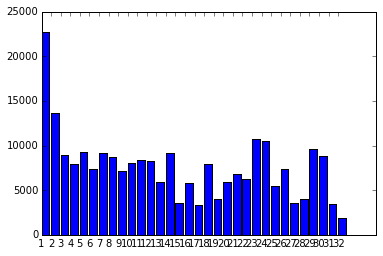

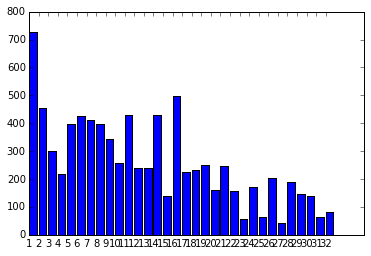

In [629]:
%matplotlib inline

def plotHist(dictValues):
    plt.bar(range(len(dictValues)), dictValues.values())
    plt.xticks(range(len(dictValues)), dictValues.keys())
    plt.show()

#plotHist(P_C)
plotHist(ssd)
plotHist(testSSE)

